## Parameters

params = Dict(
    "outdir" => "low_sp2",\
    "nx" => 192,   # number of x radial grid points\
    "ny" => 50,    # number of y collocation points\
    "nt" => 381131, # number of time steps\
    "ts" => 250,   # save every ts time steps\
    "psi_spin" => +2, # spin-weight of linear evolution scalar\
    "id_kind" => "gaussian",\
    "runtype" => "linear_field", \
    "m_vals" => [-2, 2],   # m angular values \
    "id_l_ang" => [2, 2], \
    "id_ru" => [2.5, 2.5], \
    "id_rl" => [1.1, 1.1], \
    "id_width" => [0.4, 0.4],\
    "ingoing" => true, # ingoing wave\
    # format: for each m value: [real part, imaginary part]\
    "id_amp" => [[0.0, 0.0], [1.0, 0.0]],\
    "cl" => 1.0, # compactification scale\
    "cfl" => 0.5, # CFL number\
    "bhs" => 0.7, # black hole spin \
    "bhm" => 1, # black hole mass\
    "precision" => Float64, # precision the code is compiled at\
)

## Setup and Definitions

### Imports

In [140]:
import ringdown_fits as rdf
import numpy as np
import qnm
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

### Useful functions for fitting the data

In [2]:
def QNM_spectrum(l,m,n,mass,spin):
    """ It computes the RD frequencies and damping times in NR units.
    """  
    omegas_new=modes_spec[-2,l,m,n](spin)[0]
    w_m_a = (np.real(omegas_new))/mass
    tau_m_a=-1/(np.imag(omegas_new))*mass

    return (np.array([w_m_a]), np.array([tau_m_a]))

def QNM_spectrum_w(l,m,n,mass,spin):
    """ It computes the RD frequencies and damping times in NR units.
    """  
    omegas_new=modes_spec[-2,l,m,n](spin)[0]/mass

    return omegas_new

def QNM_spectrum_re_im(l,m,n,mass,spin):
    """ It computes the RD frequencies and damping times in NR units.
    """  
    omegas_new=modes_spec[-2,l,m,n](spin)[0]
    w_re = (np.real(omegas_new))/mass
    w_im = (np.imag(omegas_new))/mass

    return w_re+1j*w_im

def delta_omega(omega_fit, omega_target):
    
    r_fit = np.real(omega_fit)
    i_fit = np.imag(omega_fit)
    
    r_target = np.real(omega_target)
    i_target = np.imag(omega_target)
    
    return np.sqrt(((r_fit-r_target)/r_target)**2 + ((i_fit-i_target)/i_target)**2)

### Load qnm spectra

In [3]:
s, l, m = [(-2,-2,-2,-2),(2,4,4,2),(0,0,4,2)]
mode_list = [(s[i], l[i], m[i], n) for n in np.arange(0,8) for i in range(len(m))]
modes_spec = { ind : qnm.modes_cache(*ind) for ind in mode_list }

### Useful functions for reading the data

In [4]:
def extract_mean_asymp(file_name:str) -> (np.array, np.array):

	times, vals=  read_times_vals_csv_2d(file_name)

	nx, ny= vals[0].shape
	ptx= nx-1

	asymptotic_vals= [np.mean(step[ptx]) for step in vals]

	return (np.array(times), np.array(asymptotic_vals))

def extract_mean_horizon(file_name:str) -> (np.array, np.array):

	times, vals=  read_times_vals_csv_2d(file_name)

	nx, ny= vals[0].shape
	ptx= 0

	asymptotic_vals= [np.mean(step[ptx]) for step in vals]

	return (np.array(times), np.array(asymptotic_vals))

def read_times_vals_csv_2d(name:str) -> (np.array,np.array):
    name= set_extension(name)
    times= []
    vals= []
    with open(name,'r') as f:
        for line in f:
            line= [v for v in line.split(',')]
            time= float(line[0])
            nx= int(line[1])
            ny= int(line[2])
            arr= np.zeros((nx,ny))
            for i in range(nx):
                for j in range(ny):
                    try:
                        arr[i][j]= float(line[3+ny*i+j])
                    except ValueError:
                        arr[i][j]= float(0)
            times.append(time)
            vals.append(arr)
    return times, np.array(vals)

def set_extension(name:str) -> str:
   if name.endswith('.csv'):
      return name
   else:
      return name+'.csv'

### Read the data and combine real and imaginary parts

In [5]:
psi4_lin_re = pd.read_csv('/home/alex/.julia/packages/TeukEvolution/9aGeD/examples/low_sp2_6/lin_f_re_2.csv')
psi4_lin_im = pd.read_csv('/home/alex/.julia/packages/TeukEvolution/9aGeD/examples/low_sp2_6/lin_f_im_2.csv')

### Null infinity

In [6]:
times, psi4_re =extract_mean_asymp('/home/alex/.julia/packages/TeukEvolution/9aGeD/examples/low_sp2_6/lin_f_re_2.csv')
times, psi4_im =extract_mean_asymp('/home/alex/.julia/packages/TeukEvolution/9aGeD/examples/low_sp2_6/lin_f_im_2.csv')

In [7]:
psi4_lin = psi4_re + 1j * psi4_im
times_shifted = times - times[0]
mask = (times_shifted >= 40) & (times_shifted <= 100)

psi4_lin_ts = np.stack((times_shifted[mask], psi4_lin[mask]), axis=1)

### Horizon

In [8]:
times_h, psi4_re_h =extract_mean_horizon('/home/alex/.julia/packages/TeukEvolution/9aGeD/examples/low_sp2_6/lin_f_re_2.csv')
times_h, psi4_im_h =extract_mean_horizon('/home/alex/.julia/packages/TeukEvolution/9aGeD/examples/low_sp2_6/lin_f_im_2.csv')

In [9]:
psi4_lin_h = psi4_re_h + 1j * psi4_im_h
times_shifted_h = times_h - times_h[0]
mask_h = (times_shifted_h >= 40) & (times_shifted_h <= 100)

psi4_lin_ts_h = np.stack((times_shifted_h[mask_h], psi4_lin_h[mask_h]), axis=1)

### Plots

/home/alex/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/alex/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


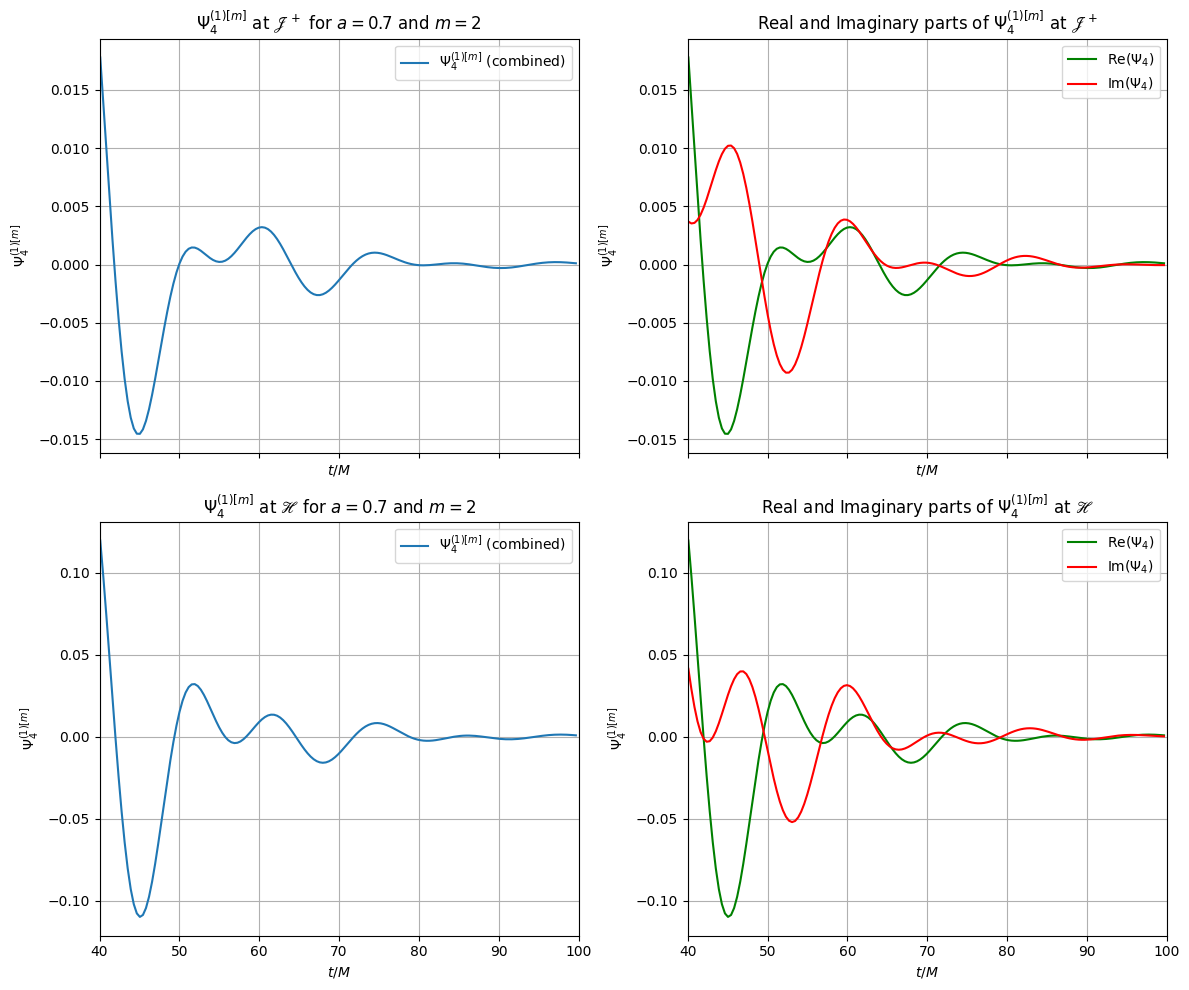

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

### --- SCRI+ ---
# 1.1 Scri+ combined
axes[0, 0].plot(psi4_lin_ts[:, 0], psi4_lin_ts[:, 1], label=r"$\Psi^{(1)[m]}_4$ (combined)")
axes[0, 0].set_xlim(40, 100)
axes[0, 0].set_title(r"$\Psi^{(1)[m]}_4$ at $\mathscr{J}^+$ for $a=0.7$ and $m=2$")
axes[0, 0].set_xlabel(r"$t/M$")
axes[0, 0].set_ylabel(r"$\Psi^{(1)[m]}_4$")
#axes[0, 0].set_yscale('log')
axes[0, 0].legend()
axes[0, 0].grid()

# 1.2 Scri+ separated
axes[0, 1].plot(psi4_lin_ts[:, 0], psi4_lin_ts[:, 1].real, label=r"Re($\Psi_4$)", color="g")
axes[0, 1].plot(psi4_lin_ts[:, 0], psi4_lin_ts[:, 1].imag, label=r"Im($\Psi_4$)", color="r")
axes[0, 1].set_xlim(40, 100)
axes[0, 1].set_title(r"Real and Imaginary parts of $\Psi^{(1)[m]}_4$ at $\mathscr{J}^+$")
axes[0, 1].set_xlabel(r"$t/M$")
axes[0, 1].set_ylabel(r"$\Psi^{(1)[m]}_4$")
#axes[0, 1].set_yscale('log')
axes[0, 1].legend()
axes[0, 1].grid()

### --- HORIZON ---
# 2.1 Horizon combined
axes[1, 0].plot(psi4_lin_ts_h[:, 0], psi4_lin_ts_h[:, 1], label=r"$\Psi^{(1)[m]}_4$ (combined)")
axes[1, 0].set_xlim(40, 100)
axes[1, 0].set_title(r"$\Psi^{(1)[m]}_4$ at $\mathscr{H}$ for $a=0.7$ and $m=2$")
axes[1, 0].set_xlabel(r"$t/M$")
axes[1, 0].set_ylabel(r"$\Psi^{(1)[m]}_4$")
#axes[1, 0].set_yscale('log')
axes[1, 0].legend()
axes[1, 0].grid()

# 2.2 Horizon separated
axes[1, 1].plot(psi4_lin_ts_h[:, 0], psi4_lin_ts_h[:, 1].real, label=r"Re($\Psi_4$)", color="g")
axes[1, 1].plot(psi4_lin_ts_h[:, 0], psi4_lin_ts_h[:, 1].imag, label=r"Im($\Psi_4$)", color="r")
axes[1, 1].set_xlim(40, 100)
axes[1, 1].set_title(r"Real and Imaginary parts of $\Psi^{(1)[m]}_4$ at $\mathscr{H}$")
axes[1, 1].set_xlabel(r"$t/M$")
axes[1, 1].set_ylabel(r"$\Psi^{(1)[m]}_4$")
#axes[1, 1].set_yscale('log')
axes[1, 1].legend()
axes[1, 1].grid()

plt.tight_layout()
plt.show()

## Analysis

### Fitting the data

The models that we are actually using to fit the data are the following ones:

- **w-tau-fixed fit:** Fits amplitude and phase while keeping $\omega$ and $\tau$ fixed, using values from QNM_spectrum.  

- **w-tau fit:** Fits all parameters, including amplitude, phase, frequency $\omega$, and damping time $\tau$.   

## w-tau-fixed 

### Horizon

In [90]:
qnmspec=np.array([QNM_spectrum(2,2,n,1,0.7) for n in range(8)]) 
args = {'qnms': qnmspec, 'real': False}

fitres_h=rdf.fit_qnm(((psi4_lin_ts_h)),[0.1,1,0.1,1],t0 = 40,linear = False, model = 'w-tau-fixed', #,0.2,2
               min_method = 'Nelder-Mead', tol=1e-8,bounds = None,**args)

fit_model_w_tau_fixed_h = rdf.rd_model_wtau_fixed(fitres_h,times = psi4_lin_ts_h[:,0],**args)

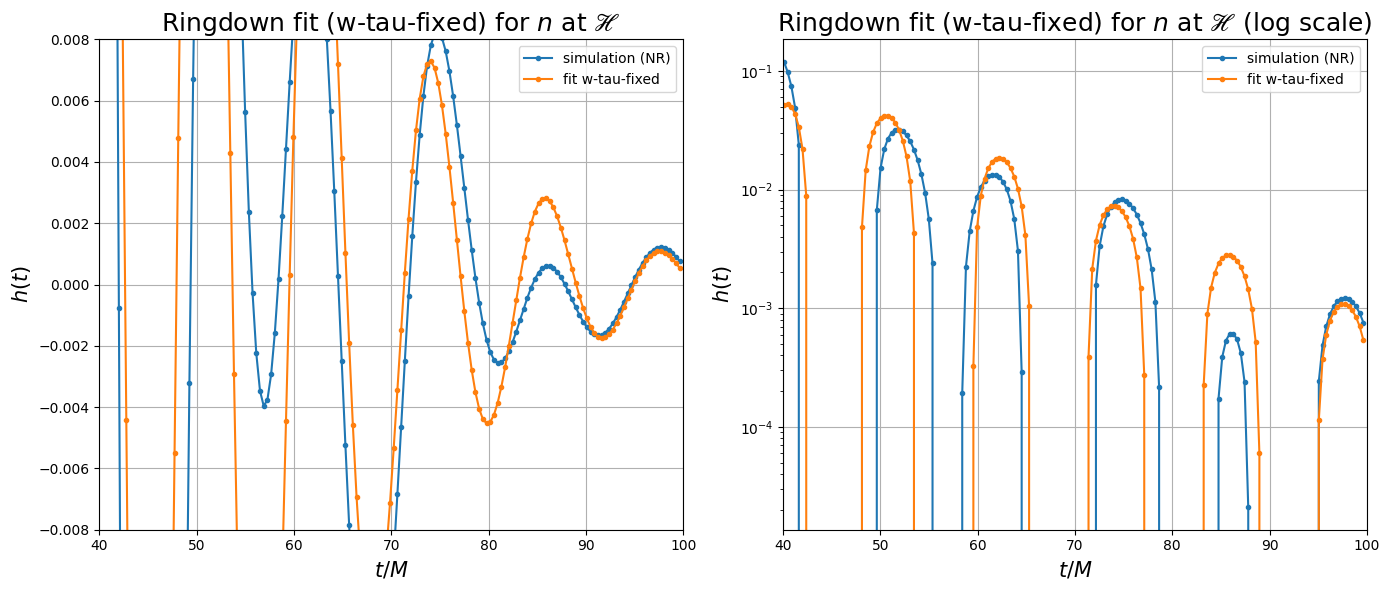

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

axes[0].plot(psi4_lin_ts_h[:,0], psi4_lin_ts_h[:,1], linestyle='-', marker='o', markersize=3, label='simulation (NR)')
#axes[0].plot(psi4_lin_ts_h[:,0], np.abs(psi4_lin_ts_h[:,1]), linestyle='-', marker='o', markersize=3, label='simulation (NR) amp')
axes[0].plot(psi4_lin_ts_h[:,0], fit_model_w_tau_fixed_h, linestyle='-', marker='o', markersize=3, label='fit w-tau-fixed')

axes[0].set_xlabel(r'$t/M$', fontsize=15)
axes[0].set_ylabel(r'$h(t)$', fontsize=15)
axes[0].set_title(r"Ringdown fit (w-tau-fixed) for $n$ at $\mathscr{H}$", fontsize=18)
axes[0].set_xlim(40, 100)
axes[0].set_ylim(-0.008, 0.008)
axes[0].legend()
axes[0].grid()

axes[1].plot(psi4_lin_ts_h[:,0], psi4_lin_ts_h[:,1], linestyle='-', marker='o', markersize=3, label='simulation (NR)')
#axes[1].plot(psi4_lin_ts_h[:,0], np.abs(psi4_lin_ts_h[:,1]), linestyle='-', marker='o', markersize=3, label='simulation (NR) amp')
axes[1].plot(psi4_lin_ts_h[:,0], fit_model_w_tau_fixed_h, linestyle='-', marker='o', markersize=3, label='fit w-tau-fixed')

axes[1].set_yscale('log')
axes[1].set_xlabel(r'$t/M$', fontsize=15)
axes[1].set_ylabel(r'$h(t)$', fontsize=15)
axes[1].set_title(r"Ringdown fit (w-tau-fixed) for $n$ at $\mathscr{H}$ (log scale)", fontsize=18)
axes[1].set_xlim(40, 100)
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

In [92]:
fitres_h

array([-2.91770326e+00,  1.67613659e+03, -1.28834711e+00,  1.03347648e+01])

### Null infinity

In [93]:
qnmspec=np.array([QNM_spectrum(2,2,n,1,0.7) for n in range(8)]) 
args = {'qnms': qnmspec, 'real': False}

fitres=rdf.fit_qnm(((psi4_lin_ts)),[0.1,2,0.2,1],t0 = 40,linear = False, model = 'w-tau-fixed', #,0.2,2
               min_method = 'Nelder-Mead', tol=1e-8,bounds = None,**args)

fit_model_w_tau_fixed = rdf.rd_model_wtau_fixed(fitres,times = psi4_lin_ts[:,0],**args)

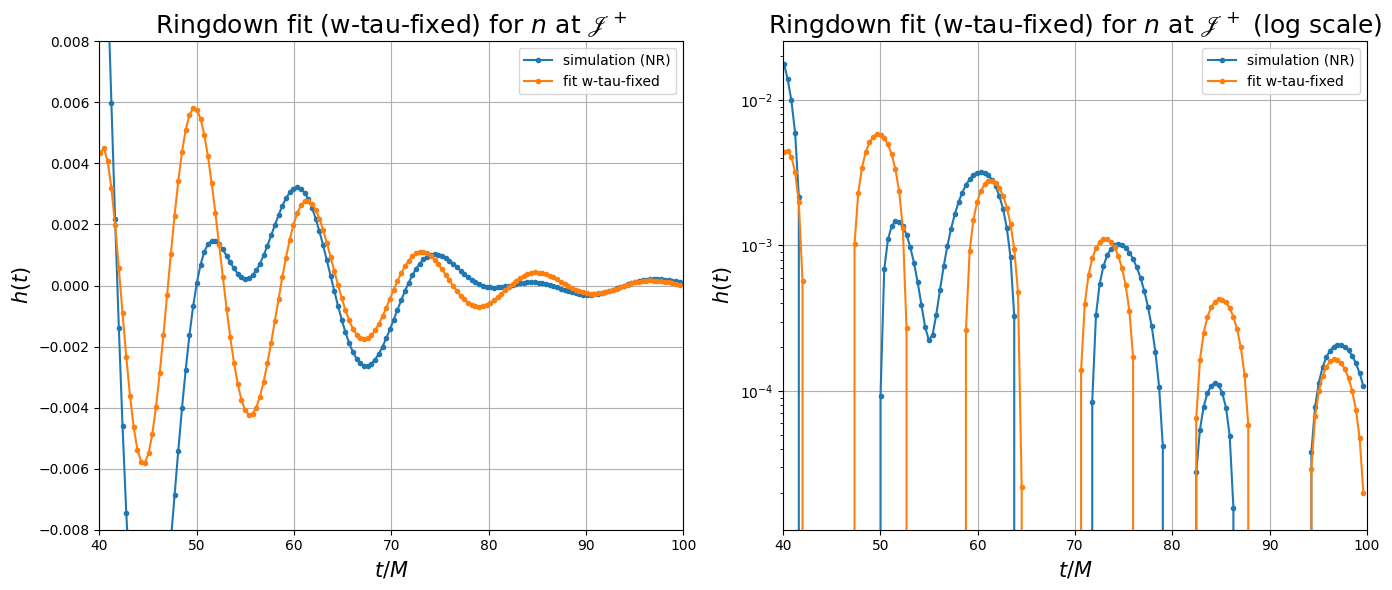

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

axes[0].plot(psi4_lin_ts[:,0], psi4_lin_ts[:,1], linestyle='-', marker='o', markersize=3, label='simulation (NR)')
#axes[0].plot(psi4_lin_ts[:,0], np.abs(psi4_lin_ts[:,1]), linestyle='-', marker='o', markersize=3, label='simulation (NR) amp')
axes[0].plot(psi4_lin_ts[:,0], fit_model_w_tau_fixed, linestyle='-', marker='o', markersize=3, label='fit w-tau-fixed')

axes[0].set_xlabel(r'$t/M$', fontsize=15)
axes[0].set_ylabel(r'$h(t)$', fontsize=15)
axes[0].set_title(r"Ringdown fit (w-tau-fixed) for $n$ at $\mathscr{J}^+$", fontsize=18)
axes[0].set_xlim(40, 100)
axes[0].set_ylim(-0.008, 0.008)
axes[0].legend()
axes[0].grid()

axes[1].plot(psi4_lin_ts[:,0], psi4_lin_ts[:,1], linestyle='-', marker='o', markersize=3, label='simulation (NR)')
#axes[1].plot(psi4_lin_ts[:,0], np.abs(psi4_lin_ts[:,1]), linestyle='-', marker='o', markersize=3, label='simulation (NR) amp')
axes[1].plot(psi4_lin_ts[:,0], fit_model_w_tau_fixed, linestyle='-', marker='o', markersize=3, label='fit w-tau-fixed')

axes[1].set_yscale('log')
axes[1].set_xlabel(r'$t/M$', fontsize=15)
axes[1].set_ylabel(r'$h(t)$', fontsize=15)
axes[1].set_title(r"Ringdown fit (w-tau-fixed) for $n$ at $\mathscr{J}^+$ (log scale)", fontsize=18)
axes[1].set_xlim(40, 100)
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

In [95]:
fitres

array([  0.41308696, 306.20435987,   1.38804073,  -2.50537327])

## w-tau 

### Horizon

In [127]:
# the fit doesn't seem to be very good, so let's try with "perfect" initial parameters
A_init = np.max(np.abs(psi4_lin_ts[:,1]))  # initial amplitude
omega_init = qnmspec[0,0][0]  # frequency from qnm
phi_init = np.pi / 4  # good (?) phase
tau_init = qnmspec[0,1][0]  # damping time also from qnm

fitres2_h = rdf.fit_qnm(((psi4_lin_ts)), [0.05, 0.0, 0.5325, 12.38], # 0.1,2,0.5,10
                         t0=40, linear=False, model='w-tau',
                         min_method='Nelder-Mead', tol=1e-8, bounds=None, **args)

fit_model_w_tau_h = rdf.rd_model_wtau(fitres2_h,times = psi4_lin_ts_h[:,0],**args)

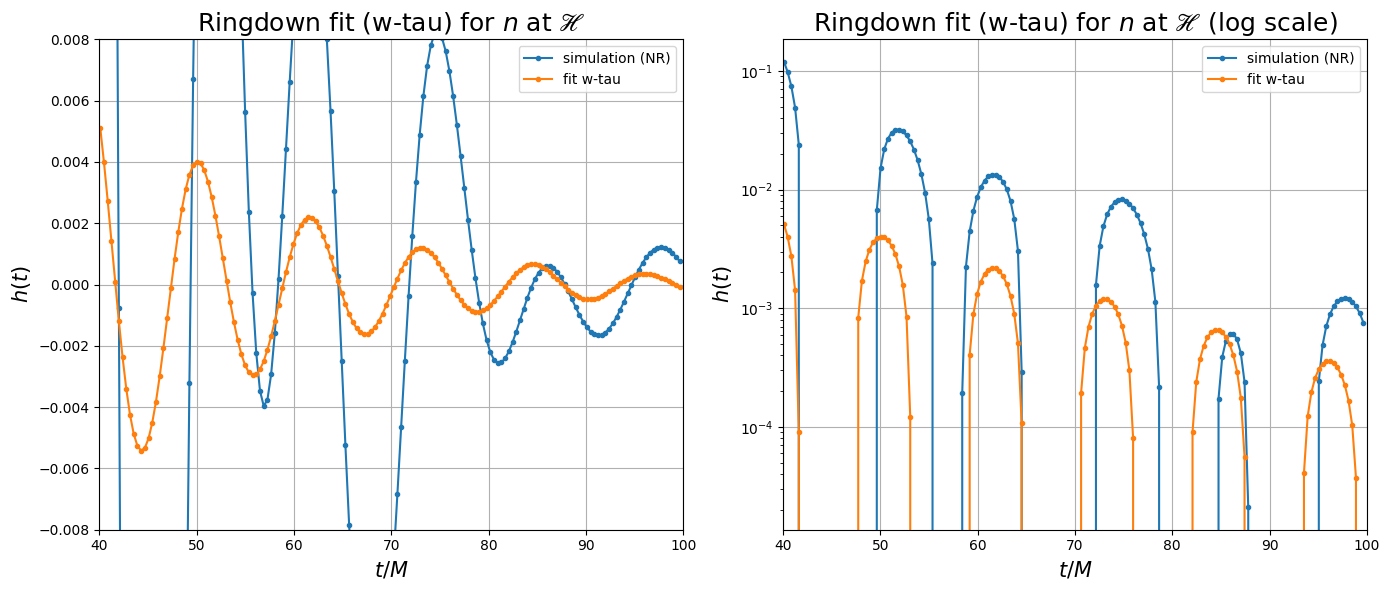

In [128]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

axes[0].plot(psi4_lin_ts_h[:,0], psi4_lin_ts_h[:,1], linestyle='-', marker='o', markersize=3, label='simulation (NR)')
#axes[0].plot(psi4_lin_ts_h[:,0], np.abs(psi4_lin_ts_h[:,1]), linestyle='-', marker='o', markersize=3, label='simulation (NR) amp')
axes[0].plot(psi4_lin_ts_h[:,0], fit_model_w_tau_h, linestyle='-', marker='o', markersize=3, label='fit w-tau')

axes[0].set_xlabel(r'$t/M$', fontsize=15)
axes[0].set_ylabel(r'$h(t)$', fontsize=15)
axes[0].set_title(r"Ringdown fit (w-tau) for $n$ at $\mathscr{H}$", fontsize=18)
axes[0].set_xlim(40, 100)
axes[0].set_ylim(-0.008, 0.008)
axes[0].legend()
axes[0].grid()

axes[1].plot(psi4_lin_ts_h[:,0], psi4_lin_ts_h[:,1], linestyle='-', marker='o', markersize=3, label='simulation (NR)')
#axes[1].plot(psi4_lin_ts_h[:,0], np.abs(psi4_lin_ts_h[:,1]), linestyle='-', marker='o', markersize=3, label='simulation (NR) amp')
axes[1].plot(psi4_lin_ts_h[:,0], fit_model_w_tau_h, linestyle='-', marker='o', markersize=3, label='fit w-tau')

axes[1].set_yscale('log')
axes[1].set_xlabel(r'$t/M$', fontsize=15)
axes[1].set_ylabel(r'$h(t)$', fontsize=15)
axes[1].set_title(r"Ringdown fit (w-tau) for $n$ at $\mathscr{H}$ (log scale)", fontsize=18)
axes[1].set_xlim(40, 100)
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

In [129]:
fitres2_h

array([ 0.05562668,  2.34598927,  0.54671942, 19.07956527])

### comparison between fitted damping times and frequencies with their theoretical values

In [130]:
print("omega_fit/omega_th =", fitres2_h[2] / qnmspec[0,0][0])
print("tau_fit/tau_th =", fitres2_h[3] / qnmspec[0,1][0])

omega_fit/omega_th = 1.0265098962055872
tau_fit/tau_th = 1.5414928965271426


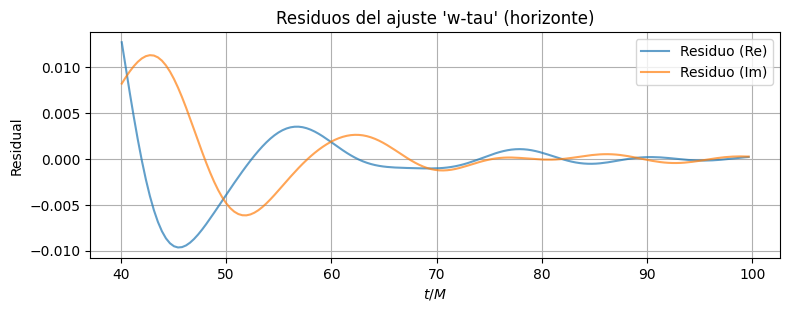

In [138]:
residual = psi4_lin_ts[:,1] - fit_model_w_tau_h

plt.figure(figsize=(8, 3))
plt.plot(psi4_lin_ts[:,0], np.real(residual), label='Residuo (Re)', alpha=0.7)
plt.plot(psi4_lin_ts[:,0], np.imag(residual), label='Residuo (Im)', alpha=0.7)
plt.xlabel(r'$t/M$')
plt.ylabel(r'Residual')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.title("Residuos del ajuste 'w-tau' (horizonte)")
plt.show()

### Null infinity

In [132]:
qnmspec=np.array([QNM_spectrum(2,2,n,1,0.7) for n in range(8)]) 
args = {'qnms': qnmspec, 'real': False}

fitres2=rdf.fit_qnm(((psi4_lin_ts)),[A_init, omega_init, phi_init, tau_init],t0 = 40,linear = False, model = 'w-tau',
               min_method = 'Nelder-Mead', tol=1e-8,bounds = None,**args)

fit_model_w_tau = rdf.rd_model_wtau(fitres2,times = psi4_lin_ts[:,0],**args)

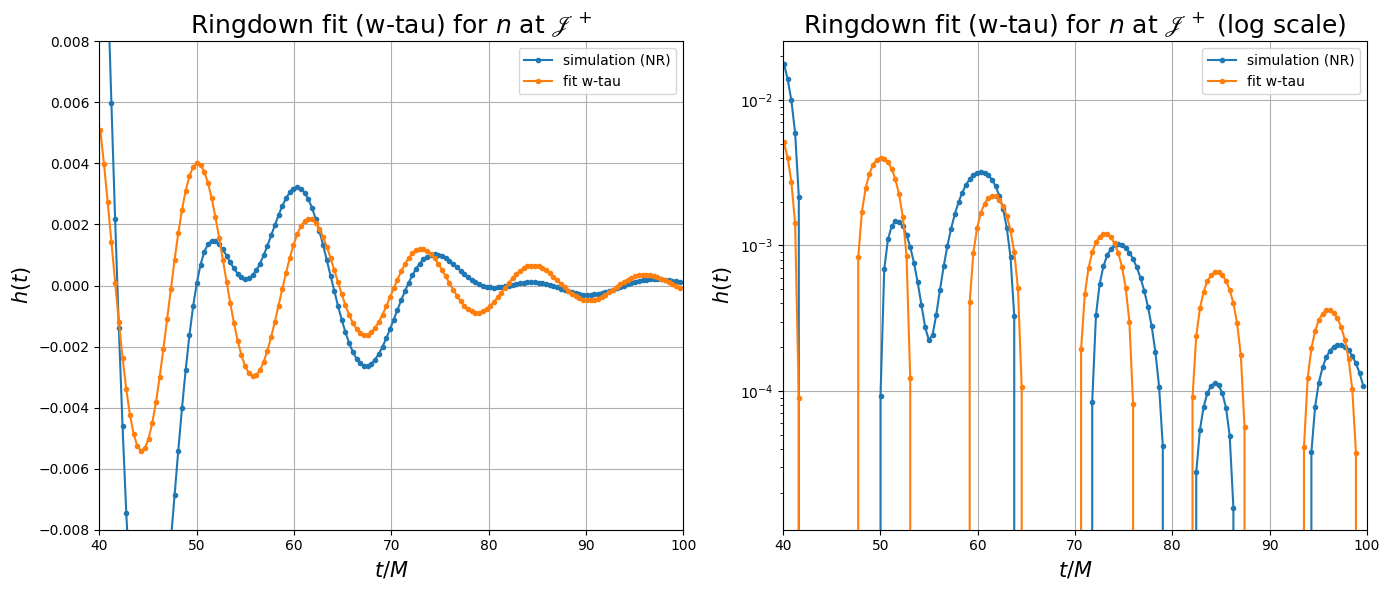

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

axes[0].plot(psi4_lin_ts[:,0], psi4_lin_ts[:,1], linestyle='-', marker='o', markersize=3, label='simulation (NR)')
#axes[0].plot(psi4_lin_ts[:,0], np.abs(psi4_lin_ts[:,1]), linestyle='-', marker='o', markersize=3, label='simulation (NR) amp')
axes[0].plot(psi4_lin_ts[:,0], fit_model_w_tau, linestyle='-', marker='o', markersize=3, label='fit w-tau')

axes[0].set_xlabel(r'$t/M$', fontsize=15)
axes[0].set_ylabel(r'$h(t)$', fontsize=15)
axes[0].set_title(r"Ringdown fit (w-tau) for $n$ at $\mathscr{J}^+$", fontsize=18)
axes[0].set_xlim(40, 100)
axes[0].set_ylim(-0.008, 0.008)
axes[0].legend()
axes[0].grid()

axes[1].plot(psi4_lin_ts[:,0], psi4_lin_ts[:,1], linestyle='-', marker='o', markersize=3, label='simulation (NR)')
#axes[1].plot(psi4_lin_ts[:,0], np.abs(psi4_lin_ts[:,1]), linestyle='-', marker='o', markersize=3, label='simulation (NR) amp')
axes[1].plot(psi4_lin_ts[:,0], fit_model_w_tau, linestyle='-', marker='o', markersize=3, label='fit w-tau')

axes[1].set_yscale('log')
axes[1].set_xlabel(r'$t/M$', fontsize=15)
axes[1].set_ylabel(r'$h(t)$', fontsize=15)
axes[1].set_title(r"Ringdown fit (w-tau) for $n$ at $\mathscr{J}^+$ (log scale)", fontsize=18)
axes[1].set_xlim(40, 100)
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

In [134]:
fitres2

array([  0.05561502, -10.22086168,   0.54671137,  19.08123817])

In [135]:
fitres2[2]/qnmspec[0,0][0],fitres2[3]/qnmspec[0,1][0]

(1.0264947873702128, 1.5416280549637562)

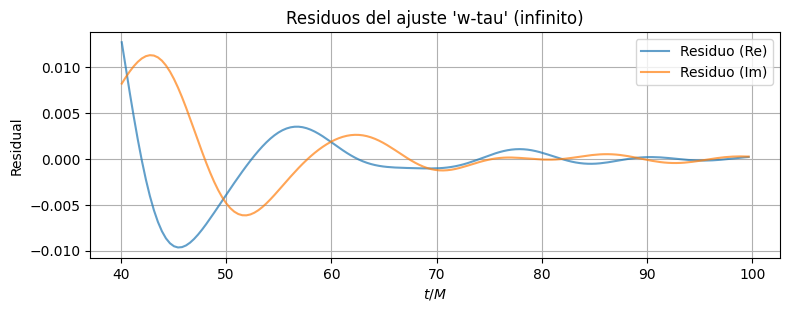

In [137]:
residual = psi4_lin_ts[:,1] - fit_model_w_tau

plt.figure(figsize=(8, 3))
plt.plot(psi4_lin_ts[:,0], np.real(residual), label='Residuo (Re)', alpha=0.7)
plt.plot(psi4_lin_ts[:,0], np.imag(residual), label='Residuo (Im)', alpha=0.7)
plt.xlabel(r'$t/M$')
plt.ylabel(r'Residual')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.title("Residuos del ajuste 'w-tau' (infinito)")
plt.show()

## Tails

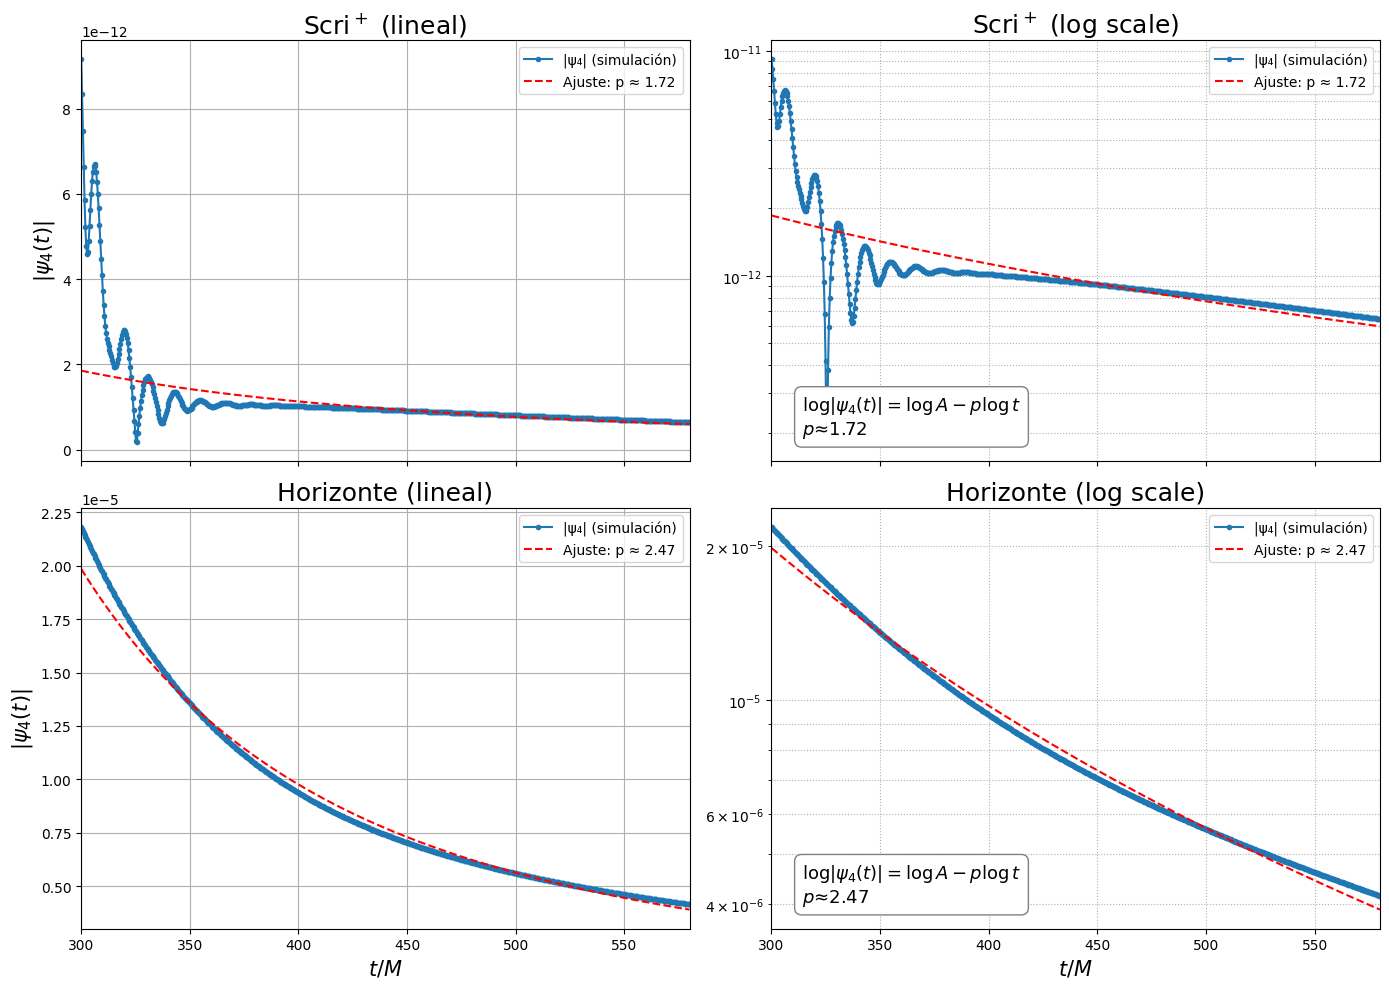

Exponente p en Scri⁺:     1.7201
Exponente p en Horizonte: 2.4710


In [141]:
# =========================================
# Modelo: log(|ψ₄|) = a - p log(t)
# =========================================
def power_law_log(t, a, p):
    return a - p * np.log(t)

def fit_tail(t, psi, tmin=300, tmax=580):
    mask = (t >= tmin) & (t <= tmax)
    t_fit = t[mask]
    psi_fit = psi[mask]

    # Evitar log(0)
    abs_psi = np.abs(psi_fit)
    valid = abs_psi > 1e-20
    t_fit = t_fit[valid]
    abs_psi = abs_psi[valid]

    log_psi = np.log(abs_psi)
    params, _ = curve_fit(power_law_log, t_fit, log_psi)
    a, p = params

    fit_vals_log = power_law_log(t_fit, a, p)
    fit_vals_lin = np.exp(fit_vals_log)

    return t_fit, abs_psi, fit_vals_lin, p

# =========================================
# Datos en Scri⁺
# =========================================
psi4_lin = psi4_re + 1j * psi4_im
t = times
t_fit_asym, abs_psi_asym, fit_asym, p_asym = fit_tail(t, psi4_lin)

# =========================================
# Datos en Horizonte
# =========================================
psi4_lin_h = psi4_re_h + 1j * psi4_im_h
t_h = times_h
t_fit_hor, abs_psi_hor, fit_hor, p_hor = fit_tail(t_h, psi4_lin_h)

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# ---------- Scri⁺ LINEAL ----------
axes[0, 0].plot(t_fit_asym, abs_psi_asym, linestyle='-', marker='o', markersize=3, label='|ψ₄| (simulación)')
axes[0, 0].plot(t_fit_asym, fit_asym, linestyle='--', color='red', label=f'Ajuste: p ≈ {p_asym:.2f}')
axes[0, 0].set_ylabel(r'$|\psi_4(t)|$', fontsize=15)
axes[0, 0].set_title(r'Scri$^+$ (lineal)', fontsize=18)
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].set_xlim(300, 580)

# ---------- Scri⁺ LOG ----------
axes[0, 1].plot(t_fit_asym, abs_psi_asym, linestyle='-', marker='o', markersize=3, label='|ψ₄| (simulación)')
axes[0, 1].plot(t_fit_asym, fit_asym, linestyle='--', color='red', label=f'Ajuste: p ≈ {p_asym:.2f}')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title(r'Scri$^+$ (log scale)', fontsize=18)
axes[0, 1].legend()
axes[0, 1].grid(True, which='both', linestyle=':')
axes[0, 1].set_xlim(300, 580)
axes[0, 1].text(
    0.05, 0.05,
    r"$\log|\psi_4(t)| = \log A - p \log t$" + f"\n$p ≈ {p_asym:.2f}$",
    transform=axes[0, 1].transAxes,
    fontsize=13,
    verticalalignment='bottom',
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4')
)

# ---------- HORIZONTE LINEAL ----------
axes[1, 0].plot(t_fit_hor, abs_psi_hor, linestyle='-', marker='o', markersize=3, label='|ψ₄| (simulación)')
axes[1, 0].plot(t_fit_hor, fit_hor, linestyle='--', color='red', label=f'Ajuste: p ≈ {p_hor:.2f}')
axes[1, 0].set_xlabel(r'$t/M$', fontsize=15)
axes[1, 0].set_ylabel(r'$|\psi_4(t)|$', fontsize=15)
axes[1, 0].set_title(r'Horizonte (lineal)', fontsize=18)
axes[1, 0].legend()
axes[1, 0].grid(True)
axes[1, 0].set_xlim(300, 580)

# ---------- HORIZONTE LOG ----------
axes[1, 1].plot(t_fit_hor, abs_psi_hor, linestyle='-', marker='o', markersize=3, label='|ψ₄| (simulación)')
axes[1, 1].plot(t_fit_hor, fit_hor, linestyle='--', color='red', label=f'Ajuste: p ≈ {p_hor:.2f}')
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlabel(r'$t/M$', fontsize=15)
axes[1, 1].set_title(r'Horizonte (log scale)', fontsize=18)
axes[1, 1].legend()
axes[1, 1].grid(True, which='both', linestyle=':')
axes[1, 1].set_xlim(300, 580)
axes[1, 1].text(
    0.05, 0.05,
    r"$\log|\psi_4(t)| = \log A - p \log t$" + f"\n$p ≈ {p_hor:.2f}$",
    transform=axes[1, 1].transAxes,
    fontsize=13,
    verticalalignment='bottom',
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4')
)

plt.tight_layout()
plt.show()
print(f"Exponente p en Scri⁺:     {p_asym:.4f}")
print(f"Exponente p en Horizonte: {p_hor:.4f}")
